In [1]:
from load_fasta import fasta_to_dict, seq_one_hot, marginal_seq_one_hot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def normalise_matrix(data, axis=0):
    """ Normalises the matrix based on the specified axis. """
    return data / np.sum(data, axis=axis, keepdims=True)

def plot_sequence_heatmap(data, filename=None, title=None, x_label="Positions", y_label="Nucleotides", y_ticks=None, batch=True, batch_size=100):
    """ Plots heatmap of sequence matrix (rows corresponds nucleotides, columns correspond to genomic location). """
    if y_ticks is None:
        y_ticks = ['A', 'C', 'G', 'T', '-', 'N']

    plt.figure(figsize=(20, 5))
    plt.imshow(data, interpolation="nearest", cmap='Blues')
    plt.xticks([], [])
    plt.xlabel(x_label)
    plt.yticks(np.arange(data.shape[0]), y_ticks[0:data.shape[0]])
    plt.ylabel(y_label)
    plt.ylim([data.shape[0] - 0.5, -0.5])
    #plt.colorbar()
    if title is not None:
        plt.title(title)
    if filename is not None:
        plt.savefig(filename)

    else:
        plt.show()
        
def find_hotspots(fasta_file, normalise=True, decimal_round=3, characters=['A', 'C', 'G', 'T', '-', 'N']):
    print("\nFinding hotspots...\n")
    
    # Create a marginal one-hot sequence matrix, meaning sum up one-hot matrices of all samples
    print("Marginal one-hot sequence matrix is creating...")
    data = marginal_seq_one_hot(fasta_file, characters=characters)
    print("\tdata.shape: ", data.shape)
    
    # Normalise data
    if normalise:
        print("Normalising the data matrix...")
        data = normalise_matrix(data)
    
    # Calculate the majority percentages
    print("Calculating the majority percentages...")
    majority_perc_dict = {}
    max_perc_list = np.max(data, axis=0)
    for pos in range(data.shape[1]):
        perc = max_perc_list[pos]
        rounded_perc = round(perc, decimal_round)
        if rounded_perc not in majority_perc_dict:
            temp = {}
            temp['count'] = 1
            temp['pos'] = [pos]
            majority_perc_dict[rounded_perc] = temp
        else:
            majority_perc_dict[rounded_perc]['count'] = majority_perc_dict[rounded_perc]['count'] + 1
            pos_list = majority_perc_dict[rounded_perc]['pos']
            pos_list.append(pos)
            majority_perc_dict[rounded_perc]['pos'] = pos_list
    for key in sorted(majority_perc_dict):
        print("\tMajority Perc.: ", key, "\tOccurrence: ", majority_perc_dict[key]['count'])#, "\tPos: ", majority_perc_dict[key]['pos'])
    print("\n\tTotal number of conflicted positions: ", data.shape[1]-majority_perc_dict[1.0]['count'])
    
    # Extract hotspot information
    print("\nExtracting hotspot information...")
    hotspots = set()
    summ = 0
    for key in sorted(majority_perc_dict):
        summ = summ + majority_perc_dict[key]['count']
        if key < 1.0:
            for pos in majority_perc_dict[key]['pos']:
                hotspots.add(pos)
    hotspots = sorted(list(hotspots))
    hotspot_mat = np.take(data, hotspots, axis=1)
    print("\thotspot_mat.shape", hotspot_mat.shape)

    return data, majority_perc_dict, hotspots, hotspot_mat

### 50/50 Training


Converting  data/2020-05-07/gisaid_cov2020.train_50.augur_seq.ali.fasta.gz  into dict...
	Number of keys in dict:  7299
	Number of observations in dict:  3650
	Maximum sequence length:  36314
	Sequence length distribution:
	Length:  36314 	Occurrence:  3650

Finding hotspots...

Marginal one-hot sequence matrix is creating...
Creating marginal of one-hot sequence matrix...
	data.shape:  (6, 36314)
Normalising the data matrix...
Calculating the majority percentages...
	Majority Perc.:  0.557 	Occurrence:  1
	Majority Perc.:  0.559 	Occurrence:  1
	Majority Perc.:  0.562 	Occurrence:  22
	Majority Perc.:  0.564 	Occurrence:  2
	Majority Perc.:  0.589 	Occurrence:  1
	Majority Perc.:  0.593 	Occurrence:  1
	Majority Perc.:  0.616 	Occurrence:  1
	Majority Perc.:  0.621 	Occurrence:  20
	Majority Perc.:  0.636 	Occurrence:  11
	Majority Perc.:  0.723 	Occurrence:  3
	Majority Perc.:  0.724 	Occurrence:  1
	Majority Perc.:  0.732 	Occurrence:  1
	Majority Perc.:  0.771 	Occurrence:  3
	Maj

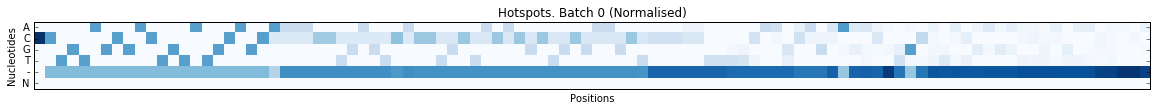

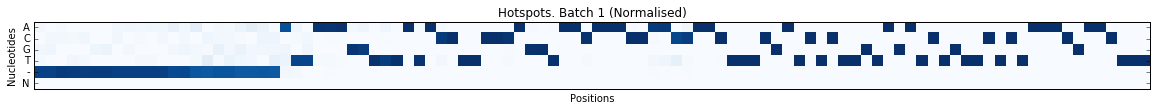

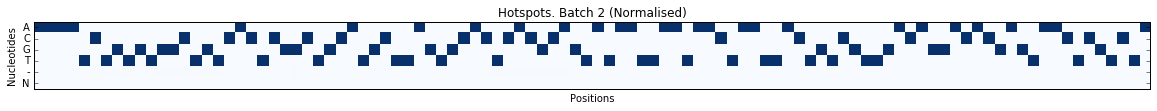

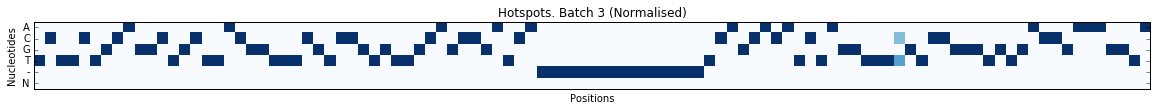

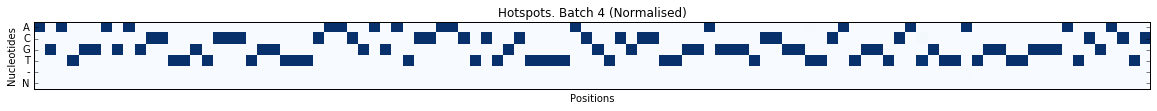

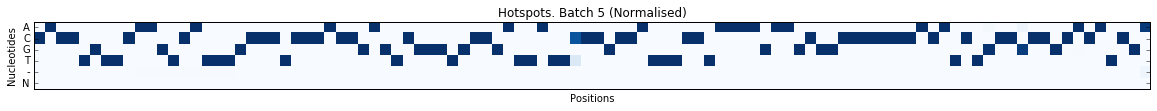

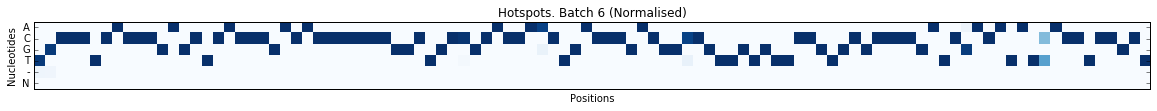

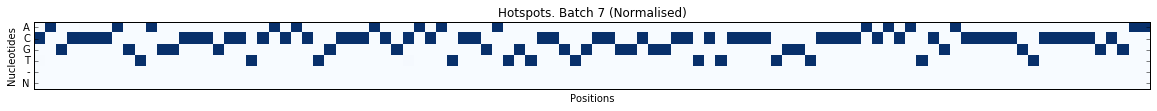

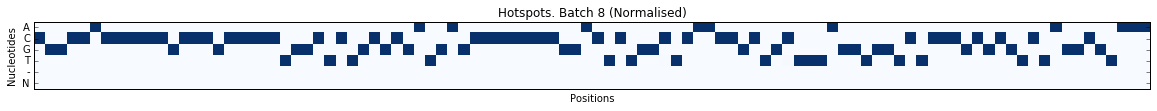

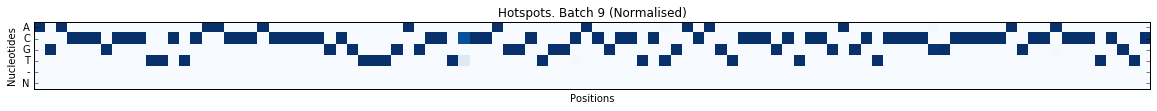

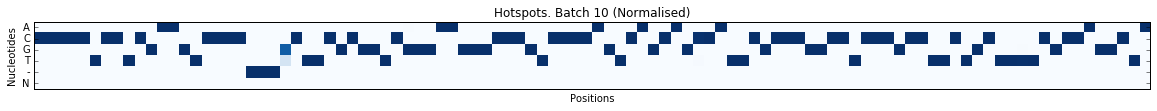

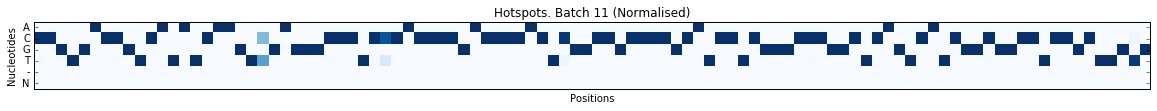

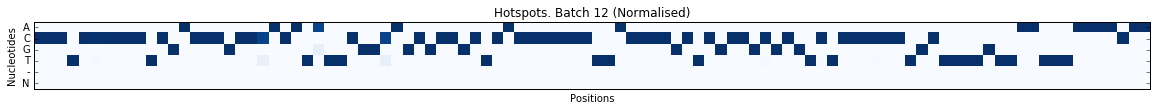

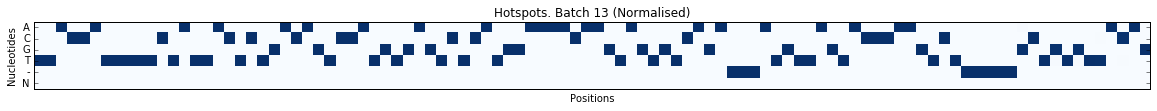

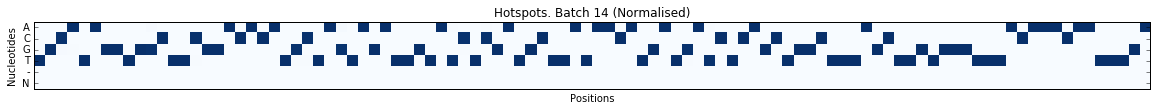

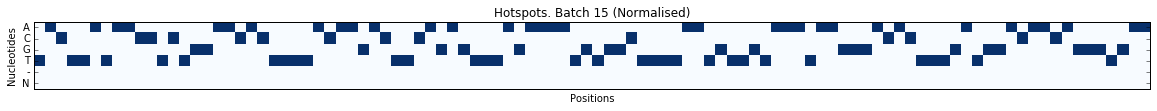

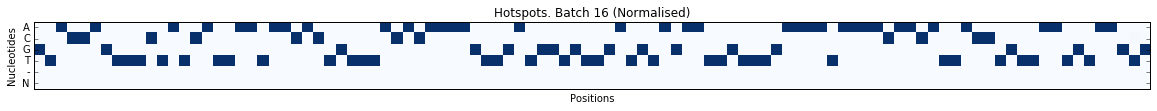

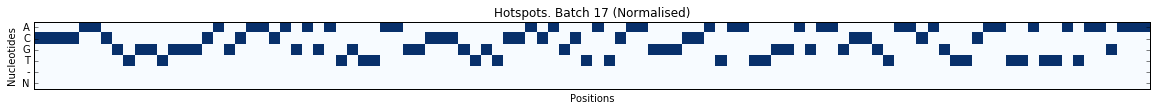

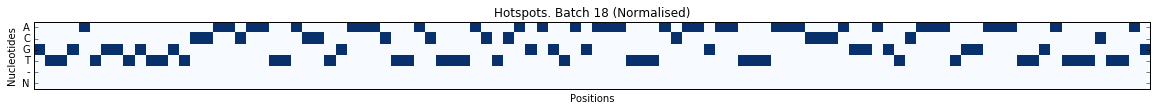

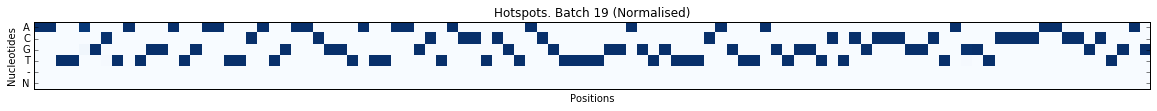

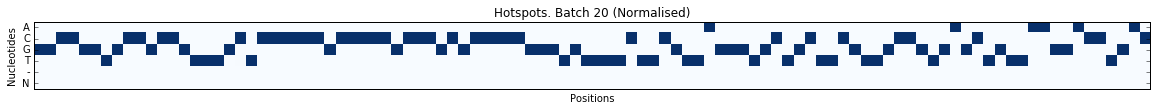

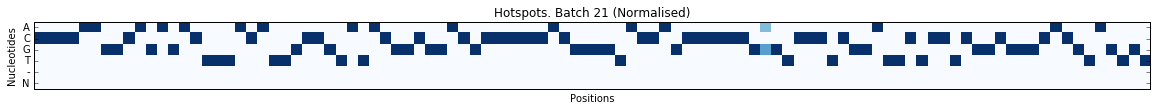

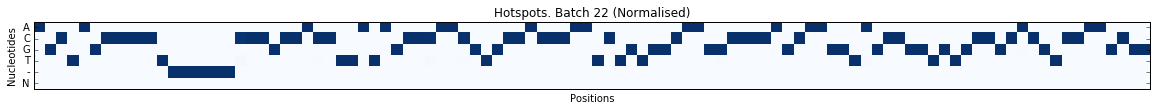

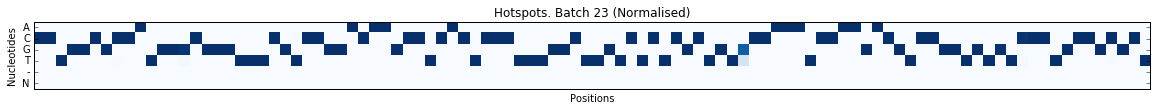

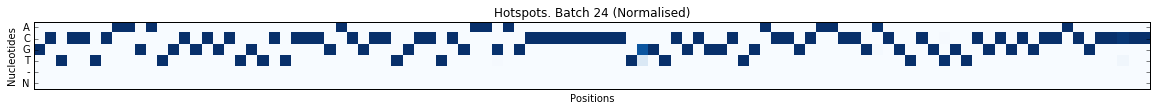

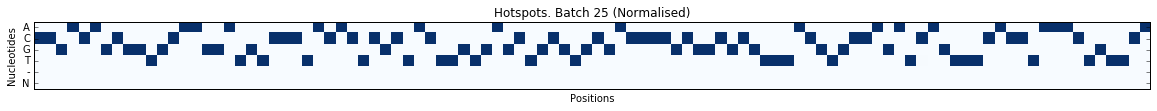

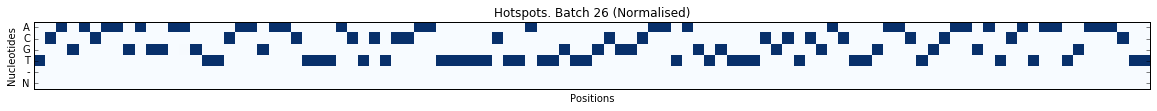

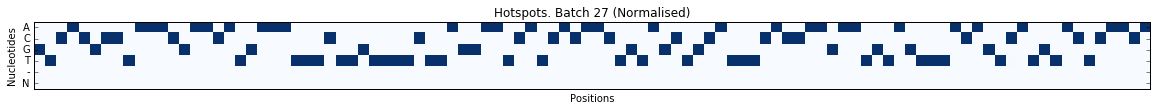

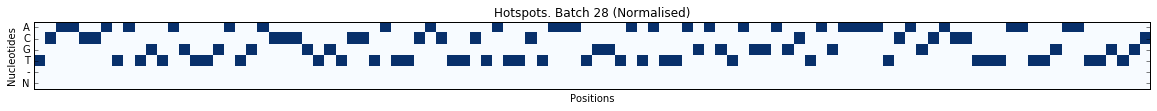

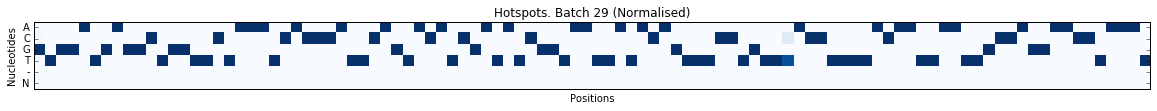

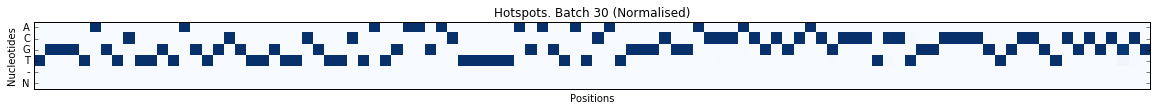

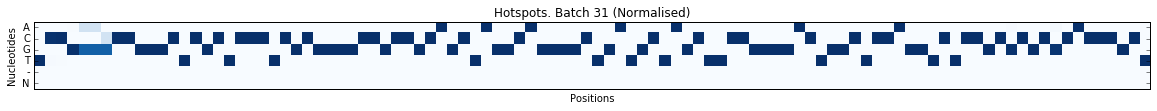

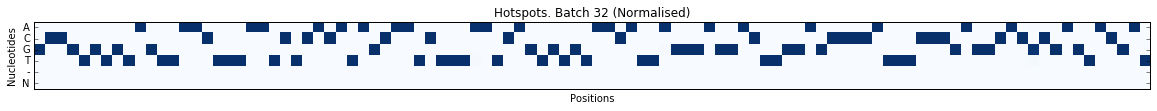

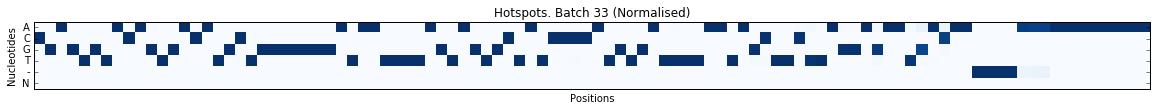

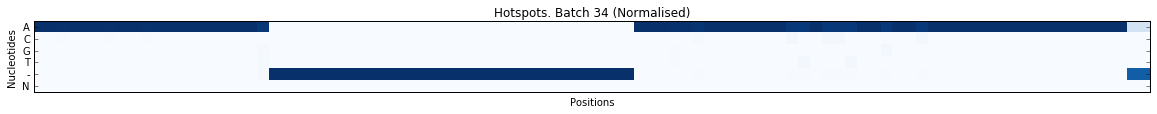

In [3]:
# Load a fasta file and convert it into a dict
infile = 'data/2020-05-07/gisaid_cov2020.train_50.augur_seq.ali.fasta.gz'
print("\nConverting ", infile, " into dict...")
fasta_file_temp = fasta_to_dict(infile)
print("\tNumber of keys in dict: ", len(list(fasta_file_temp.keys())))

# Work only with the leaves
max_length = 0
length_dist = {}
fasta_file = {}
for key in fasta_file_temp:
    if key[0:3] == "EPI":
        fasta_file[key] = fasta_file_temp[key]
        seq_len = len(fasta_file[key])
        max_length = max(max_length, seq_len)
        if seq_len not in length_dist:
            length_dist[seq_len] = 1
        else:
            length_dist[seq_len] = length_dist[seq_len] + 1
        
print("\tNumber of observations in dict: ", len(list(fasta_file.keys())))
print("\tMaximum sequence length: ", max_length)
print("\tSequence length distribution:")
for key in sorted(length_dist.keys()):
    print("\tLength: ", key, "\tOccurrence: ", length_dist[key])
    
train_data, train_majority_perc_dict, train_hotspots, train_hotspot_mat = find_hotspots(fasta_file)

print("\nVisualising the selected hotspots data...")
plot_data = np.copy(train_hotspot_mat)
batch_size = 100
i=0
while (i+1)*batch_size <= plot_data.shape[1]:
    plot_sequence_heatmap(plot_data[:,i*batch_size:(i+1)*batch_size], title="Hotspots. Batch %d (Normalised)" % i)
    i = i+1
plot_sequence_heatmap(plot_data[:,i*batch_size:min((i+1)*batch_size, plot_data.shape[1])], title="Hotspots. Batch %d (Normalised)" % i)

In [4]:
train_hotspot_mat.shape

(6, 3495)

In [9]:
print(train_hotspots)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 

In [10]:
train_hotspot_mat[:,0]

array([  0.00000000e+00,   9.99452055e-01,   0.00000000e+00,
         2.73972603e-04,   2.73972603e-04,   0.00000000e+00])

In [35]:
import csv

a = np.transpose(np.vstack((np.array(train_hotspots), train_hotspot_mat)))
filename = "data/2020-05-07/gisaid_cov2020.train_50.hotspots.txt"
np.savetxt(filename, a, fmt='%i'+'\t%1.5f'*6)

In [31]:
b = np.loadtxt(filename)
b.shape

(3495, 7)

### 50/50 Test

In [37]:
# Load a fasta file and convert it into a dict
infile = 'data/2020-05-07/gisaid_cov2020.test_50.augur_seq.ali.fasta.gz'
print("\nConverting ", infile, " into dict...")
fasta_file_temp = fasta_to_dict(infile)
print("\tNumber of keys in dict: ", len(list(fasta_file_temp.keys())))

# Work only with the leaves
max_length = 0
length_dist = {}
fasta_file = {}
for key in fasta_file_temp:
    if key[0:3] == "EPI":
        fasta_file[key] = fasta_file_temp[key]
        seq_len = len(fasta_file[key])
        max_length = max(max_length, seq_len)
        if seq_len not in length_dist:
            length_dist[seq_len] = 1
        else:
            length_dist[seq_len] = length_dist[seq_len] + 1
        
print("\tNumber of observations in dict: ", len(list(fasta_file.keys())))
print("\tMaximum sequence length: ", max_length)
print("\tSequence length distribution:")
for key in sorted(length_dist.keys()):
    print("\tLength: ", key, "\tOccurrence: ", length_dist[key])
    
test_data, test_majority_perc_dict, test_hotspots, test_hotspot_mat = find_hotspots(fasta_file)

import csv

a = np.transpose(np.vstack((np.array(test_hotspots), test_hotspot_mat)))
filename = "data/2020-05-07/gisaid_cov2020.test_50.hotspots.txt"
np.savetxt(filename, a, fmt='%i'+'\t%1.5f'*6)


Converting  data/2020-05-07/gisaid_cov2020.test_50.augur_seq.ali.fasta.gz  into dict...
	Number of keys in dict:  7299
	Number of observations in dict:  3650
	Maximum sequence length:  34292
	Sequence length distribution:
	Length:  34292 	Occurrence:  3650

Finding hotspots...

Marginal one-hot sequence matrix is creating...
Creating marginal of one-hot sequence matrix...
	data.shape:  (6, 34292)
Normalising the data matrix...
Calculating the majority percentages...
	Majority Perc.:  0.471 	Occurrence:  1
	Majority Perc.:  0.559 	Occurrence:  1
	Majority Perc.:  0.563 	Occurrence:  1
	Majority Perc.:  0.564 	Occurrence:  1
	Majority Perc.:  0.565 	Occurrence:  1
	Majority Perc.:  0.591 	Occurrence:  1
	Majority Perc.:  0.593 	Occurrence:  1
	Majority Perc.:  0.642 	Occurrence:  8
	Majority Perc.:  0.655 	Occurrence:  1
	Majority Perc.:  0.659 	Occurrence:  1
	Majority Perc.:  0.664 	Occurrence:  1
	Majority Perc.:  0.667 	Occurrence:  2
	Majority Perc.:  0.731 	Occurrence:  1
	Majorit

### 80/20 Training

In [38]:
# Load a fasta file and convert it into a dict
infile = 'data/2020-05-07/gisaid_cov2020.train_80.augur_seq.ali.fasta.gz'
print("\nConverting ", infile, " into dict...")
fasta_file_temp = fasta_to_dict(infile)
print("\tNumber of keys in dict: ", len(list(fasta_file_temp.keys())))

# Work only with the leaves
max_length = 0
length_dist = {}
fasta_file = {}
for key in fasta_file_temp:
    if key[0:3] == "EPI":
        fasta_file[key] = fasta_file_temp[key]
        seq_len = len(fasta_file[key])
        max_length = max(max_length, seq_len)
        if seq_len not in length_dist:
            length_dist[seq_len] = 1
        else:
            length_dist[seq_len] = length_dist[seq_len] + 1
        
print("\tNumber of observations in dict: ", len(list(fasta_file.keys())))
print("\tMaximum sequence length: ", max_length)
print("\tSequence length distribution:")
for key in sorted(length_dist.keys()):
    print("\tLength: ", key, "\tOccurrence: ", length_dist[key])
    
train_data, train_majority_perc_dict, train_hotspots, train_hotspot_mat = find_hotspots(fasta_file)

import csv

a = np.transpose(np.vstack((np.array(train_hotspots), train_hotspot_mat)))
filename = "data/2020-05-07/gisaid_cov2020.train_80.hotspots.txt"
np.savetxt(filename, a, fmt='%i'+'\t%1.5f'*6)


Converting  data/2020-05-07/gisaid_cov2020.train_80.augur_seq.ali.fasta.gz  into dict...
	Number of keys in dict:  11677
	Number of observations in dict:  5839
	Maximum sequence length:  38245
	Sequence length distribution:
	Length:  38245 	Occurrence:  5839

Finding hotspots...

Marginal one-hot sequence matrix is creating...
Creating marginal of one-hot sequence matrix...
	data.shape:  (6, 38245)
Normalising the data matrix...
Calculating the majority percentages...
	Majority Perc.:  0.455 	Occurrence:  1
	Majority Perc.:  0.536 	Occurrence:  1
	Majority Perc.:  0.562 	Occurrence:  1
	Majority Perc.:  0.564 	Occurrence:  1
	Majority Perc.:  0.566 	Occurrence:  1
	Majority Perc.:  0.567 	Occurrence:  1
	Majority Perc.:  0.569 	Occurrence:  1
	Majority Perc.:  0.574 	Occurrence:  1
	Majority Perc.:  0.577 	Occurrence:  1
	Majority Perc.:  0.578 	Occurrence:  2
	Majority Perc.:  0.6 	Occurrence:  1
	Majority Perc.:  0.606 	Occurrence:  17
	Majority Perc.:  0.607 	Occurrence:  21
	Major

### 80/20 Test

In [39]:
# Load a fasta file and convert it into a dict
infile = 'data/2020-05-07/gisaid_cov2020.test_20.augur_seq.ali.fasta.gz'
print("\nConverting ", infile, " into dict...")
fasta_file_temp = fasta_to_dict(infile)
print("\tNumber of keys in dict: ", len(list(fasta_file_temp.keys())))

# Work only with the leaves
max_length = 0
length_dist = {}
fasta_file = {}
for key in fasta_file_temp:
    if key[0:3] == "EPI":
        fasta_file[key] = fasta_file_temp[key]
        seq_len = len(fasta_file[key])
        max_length = max(max_length, seq_len)
        if seq_len not in length_dist:
            length_dist[seq_len] = 1
        else:
            length_dist[seq_len] = length_dist[seq_len] + 1
        
print("\tNumber of observations in dict: ", len(list(fasta_file.keys())))
print("\tMaximum sequence length: ", max_length)
print("\tSequence length distribution:")
for key in sorted(length_dist.keys()):
    print("\tLength: ", key, "\tOccurrence: ", length_dist[key])
    
test_data, test_majority_perc_dict, test_hotspots, test_hotspot_mat = find_hotspots(fasta_file)

a = np.transpose(np.vstack((np.array(test_hotspots), test_hotspot_mat)))
filename = "data/2020-05-07/gisaid_cov2020.test_20.hotspots.txt"
np.savetxt(filename, a, fmt='%i'+'\t%1.5f'*6)


Converting  data/2020-05-07/gisaid_cov2020.test_20.augur_seq.ali.fasta.gz  into dict...
	Number of keys in dict:  2921
	Number of observations in dict:  1461
	Maximum sequence length:  31832
	Sequence length distribution:
	Length:  31832 	Occurrence:  1461

Finding hotspots...

Marginal one-hot sequence matrix is creating...
Creating marginal of one-hot sequence matrix...
	data.shape:  (6, 31832)
Normalising the data matrix...
Calculating the majority percentages...
	Majority Perc.:  0.507 	Occurrence:  1
	Majority Perc.:  0.543 	Occurrence:  1
	Majority Perc.:  0.546 	Occurrence:  1
	Majority Perc.:  0.548 	Occurrence:  1
	Majority Perc.:  0.55 	Occurrence:  1
	Majority Perc.:  0.551 	Occurrence:  1
	Majority Perc.:  0.709 	Occurrence:  1
	Majority Perc.:  0.71 	Occurrence:  3
	Majority Perc.:  0.711 	Occurrence:  6
	Majority Perc.:  0.745 	Occurrence:  33
	Majority Perc.:  0.754 	Occurrence:  1
	Majority Perc.:  0.784 	Occurrence:  1
	Majority Perc.:  0.802 	Occurrence:  2
	Majority